In [1]:
!pip install sb3-contrib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback


import sys
sys.path.append("/Users/pnl1f276/code/bennystu/trend_surgeon/Trend-Surgeon-Time-Series/ts_boilerplate")

from gym_anytrading.envs.flexible_env import FlexibleTradingEnv
from dataprep import build_feature_dataset, get_X_y

In [3]:
df = build_feature_dataset()

--- Data Integrity Report ---
Rows: 2,891, Columns: 33
Index sorted: True
Index unique: True
Rows that are entirely NaN: 0
Inf values: 0

Top columns with NaNs:
  (None)

--- Data Integrity Report ---
Rows: 2,891, Columns: 33
Index sorted: True
Index unique: True
Rows that are entirely NaN: 0
Inf values: 0

Top columns with NaNs:
  (None)

Markdown feature documentation written to: ../docs/feature_documentation.md


In [4]:
df.head()

,PPH_Open,PPH_High,PPH_Low,PPH_Close,PPH_Volume,XPH_Open,XPH_High,XPH_Low,XPH_Close,XPH_Volume,...,XPH_Ratio_PPH_t-1,day_of_week,day_of_month,month,quarter,is_holiday_adjacent,days_to_cpi,days_since_cpi,days_to_nfp,days_since_nfp
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-04,53.450001,53.700001,53.369999,53.680000,117000,44.595001,44.820000,44.215000,44.490002,180200,...,0.833804,1,4,2,1,0,9,24,32,2
2014-02-05,53.799999,53.959999,53.450001,53.840000,40400,44.430000,44.509998,43.535000,44.299999,184400,...,0.828800,2,5,2,1,0,8,25,31,3
2014-02-06,53.959999,54.090000,53.790001,53.959999,24200,44.610001,44.775002,43.970001,44.195000,76800,...,0.822808,3,6,2,1,0,7,26,30,4
2014-02-07,54.200001,54.959999,54.139999,54.959999,36100,44.419998,45.349998,44.244999,45.349998,186800,...,0.819033,4,7,2,1,0,6,27,29,5
2014-02-10,55.029999,55.349998,54.900002,55.349998,173000,45.424999,45.959999,45.185001,45.959999,127200,...,0.825146,0,10,2,1,0,3,30,26,8


In [5]:
prices = df["target_close"].values.astype(np.float32)

feature_cols = df.columns.drop("target_close")
signal_features = df[feature_cols].values.astype(np.float32)

In [6]:
window_size = 30
frame_bound = (window_size, len(df))

In [7]:
def make_env():
    def _init():
        return FlexibleTradingEnv(
            df=df,
            prices=prices,
            signal_features=signal_features,
            window_size=window_size,
            frame_bound=frame_bound,
            fee=0.0005,
            holding_cost=0.00001,
            render_mode=None
        )
    return _init


In [8]:
train_env = SubprocVecEnv([make_env() for _ in range(4)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_reward=np.inf)

eval_env = DummyVecEnv([make_env()])  # IMPORTANT: only 1 env
eval_env = VecNormalize.load("vec_normalize.pkl", eval_env)

eval_env.training = False
eval_env.norm_reward = False


In [9]:
model = RecurrentPPO(
    policy="MlpLstmPolicy",
    env=train_env,
    # ↓ LOWER COMPUTE LOAD, still good for trading
    learning_rate=2e-4,     # slightly higher LR → fewer updates needed
    n_steps=512,            # HALF rollout length = half the RAM + half compute
    batch_size=128,         # must divide n_steps * n_envs cleanly
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.0,
    verbose=1,
    tensorboard_log="./ppo_lstm_logs/",
    clip_range=0.0,
    max_grad_norm=0.5
)


Using cpu device


In [10]:
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./ppo_best_model/",
    log_path="./ppo_eval_logs/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=10000,
    save_path="./ppo_checkpoints/",
    name_prefix="ppo_trading_model"
)


In [11]:
model.learn(
    total_timesteps=200_000,
    callback=[eval_callback, checkpoint_callback]
)

model.save("recurrent_ppo_trading")
train_env.save("vec_normalize.pkl")

Logging to ./ppo_lstm_logs/RecurrentPPO_2
-----------------------------
| time/              |      |
|    fps             | 5417 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 561           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 7.9366146e-07 |
|    clip_fraction        | 0.994         |
|    clip_range           | 0             |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.0443        |
|    learning_rate        | 0.0002        |
|    loss                 | 0.172         |
|    n_updates            | 10            |
|    policy_gradient_loss | 0.000415      |
|    value_loss           | 0.685         |


/Users/pnl1f276/.pyenv/versions/3.10.6/envs/StockProphet/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=1.07 +/- 0.00
Episode length: 2860.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 2.86e+03      |
|    mean_reward          | 1.07          |
| time/                   |               |
|    total_timesteps      | 20000         |
| train/                  |               |
|    approx_kl            | 2.0881998e-07 |
|    clip_fraction        | 0.994         |
|    clip_range           | 0             |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.0665        |
|    learning_rate        | 0.0002        |
|    loss                 | 0.133         |
|    n_updates            | 90            |
|    policy_gradient_loss | 0.000141      |
|    value_loss           | 0.35          |
-------------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 387   |
|    

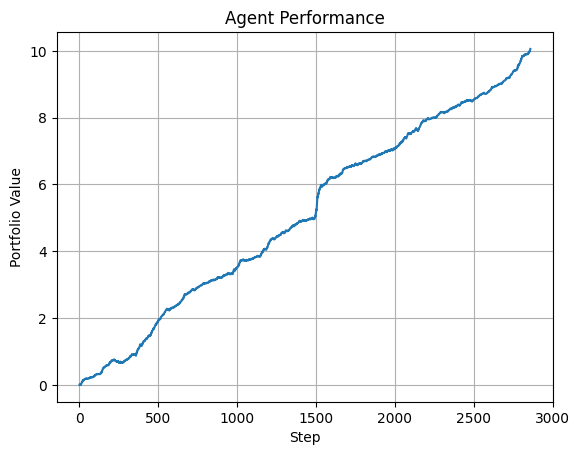

In [12]:
from sb3_contrib import RecurrentPPO
import numpy as np
import matplotlib.pyplot as plt

eval_env = DummyVecEnv([make_env()])
eval_env = VecNormalize.load("vec_normalize.pkl", eval_env)
eval_env.training = False
eval_env.norm_reward = False

model = RecurrentPPO.load("recurrent_ppo_trading")

obs = eval_env.reset()
done = False
profits = []

lstm_state = None
episode_start = np.array([True], dtype=bool)

while True:
    action, lstm_state = model.predict(
        obs,
        state=lstm_state,
        episode_start=episode_start,
        deterministic=True
    )

    obs, reward, done, info = eval_env.step(action)

    # SB3 vector env -> arrays
    done = bool(done[0])
    info = info[0]

    episode_start = np.array([done], dtype=bool)

    profits.append(info["total_profit"])

    if done:
        break

plt.plot(profits)
plt.title("Agent Performance")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_agent(model, vec_env, raw_prices, episodes=1, force_long=False):
    """
    Robust evaluation for PPO/RecurrentPPO + VecNormalize.

    PARAMETERS
    ----------
    model : SB3 model
        Trained PPO or RecurrentPPO model.
    vec_env : VecNormalize-wrapped VecEnv
        Environment wrapper with normalization disabled for eval.
    raw_prices : np.array
        Unshifted real prices used for Buy & Hold baseline.
    episodes : int
        Number of evaluation episodes.
    force_long : bool
        If True → agent always takes action=1 (always long).
        Useful for debugging graph correctness.

    WHAT THIS COMPUTES
    -------------------
    • Proper PPO equity curve (exp of log cumulative returns)
    • Buy & Hold curve (price_normalized)
    • Total trades
    • Sharpe-like metric
    • Max Drawdown
    • Clean dual-axis plot
    """

    print("\n=== EVALUATION STARTED ===")

    for ep in range(episodes):

        # Reset environment + LSTM
        obs = vec_env.reset()
        lstm_state = None
        episode_start = np.array([True], dtype=bool)

        done = False
        steps = 0

        log_pnl = []     # stores cumulative log-pnl values from env
        positions = []   # used to count trades

        while not done:
            if force_long:
                # Override model output for debugging
                action = np.array([1])
                lstm_state = None
            else:
                # RecurrentPPO prediction
                action, lstm_state = model.predict(
                    obs,
                    state=lstm_state,
                    episode_start=episode_start,
                    deterministic=True
                )

            # SB3 VecEnv → returns obs, reward, done, info (4 values)
            obs, reward, done, info = vec_env.step(action)

            done = bool(done[0])
            info = info[0]

            if steps < 10:
                print(f"step {steps}   reward={reward}   total_profit(info)={info['total_profit']}")

            # Store cumulative log-pnl (your env outputs this)
            log_pnl.append(info["total_profit"])
            positions.append(info["position"])
            print(f"pos={info['position']}, reward={reward}, total_profit={info['total_profit']}")
            episode_start = np.array([done], dtype=bool)
            steps += 1

        # ---------------------------------------------------------------------
        # Convert log returns → equity curve
        # log_pnl[t] = sum of log returns up to t
        # equity[t] = exp(log_pnl[t])
        # ---------------------------------------------------------------------
        log_pnl = np.array(log_pnl)
        ppo_equity = 1 + np.array(log_pnl)


        # ---------------------------------------------------------------------
        # Buy & Hold baseline (raw unshifted close prices)
        # ---------------------------------------------------------------------
        price_segment = raw_prices[:steps]
        buy_hold = price_segment / price_segment[0]

        # ---------------------------------------------------------------------
        # Metrics
        # ---------------------------------------------------------------------
        final_equity = ppo_equity[-1]
        returns_log = np.diff(np.log(ppo_equity + 1e-12))

        sharpe_like = np.mean(returns_log) / (np.std(returns_log) + 1e-8)
        mdd = np.max(np.maximum.accumulate(ppo_equity) - ppo_equity)
        trades = int(np.sum(np.diff(positions) != 0))

        print(f"\nEpisode {ep+1} Results:")
        print(f"• Final Equity:        {final_equity:.2f}")
        print(f"• Total Steps:         {steps}")
        print(f"• Total Trades:        {trades}")
        print(f"• Sharpe-like Metric:  {sharpe_like:.4f}")
        print(f"• Max Drawdown:        {mdd:.2f}")

        # ---------------------------------------------------------------------
        # PLOTTING
        # ---------------------------------------------------------------------
        fig, ax1 = plt.subplots(figsize=(13, 6))

        # LEFT AXIS → stock price
        ax1.plot(price_segment, color="blue", alpha=0.5, label="Stock Price")
        ax1.set_ylabel("Price", color="blue")
        ax1.tick_params(axis="y", labelcolor="blue")

        # RIGHT AXIS → portfolios
        ax2 = ax1.twinx()
        ax2.plot(ppo_equity, label="PPO Portfolio", color="green", linewidth=2)
        ax2.plot(buy_hold, label="Buy & Hold", color="gray", linestyle="--")
        ax2.set_ylabel("Equity", color="green")
        ax2.tick_params(axis="y", labelcolor="green")

        # Final formatting
        ax1.grid(alpha=0.3)
        ax2.legend(loc="upper left")
        fig.suptitle(f"PPO Evaluation — Episode {ep+1}")

        plt.show()

    print("\n=== EVALUATION COMPLETE ===\n")



=== EVALUATION STARTED ===
step 0   reward=[-0.0005]   total_profit(info)=-0.0005
pos=-1, reward=[-0.0005], total_profit=-0.0005
step 1   reward=[0.01320341]   total_profit(info)=0.012703413400464924
pos=-1, reward=[0.01320341], total_profit=0.012703413400464924
step 2   reward=[0.01145642]   total_profit(info)=0.024159832525734802
pos=-1, reward=[0.01145642], total_profit=0.024159832525734802
step 3   reward=[-0.00888197]   total_profit(info)=0.015277857643896936
pos=-1, reward=[-0.00888197], total_profit=0.015277857643896936
step 4   reward=[0.0031123]   total_profit(info)=0.018390155070486337
pos=-1, reward=[0.0031123], total_profit=0.018390155070486337
step 5   reward=[-0.00053104]   total_profit(info)=0.01785911677994298
pos=-1, reward=[-0.00053104], total_profit=0.01785911677994298
step 6   reward=[0.00120622]   total_profit(info)=0.019065339576948826
pos=-1, reward=[0.00120622], total_profit=0.019065339576948826
step 7   reward=[-0.01467932]   total_profit(info)=0.0043860200314

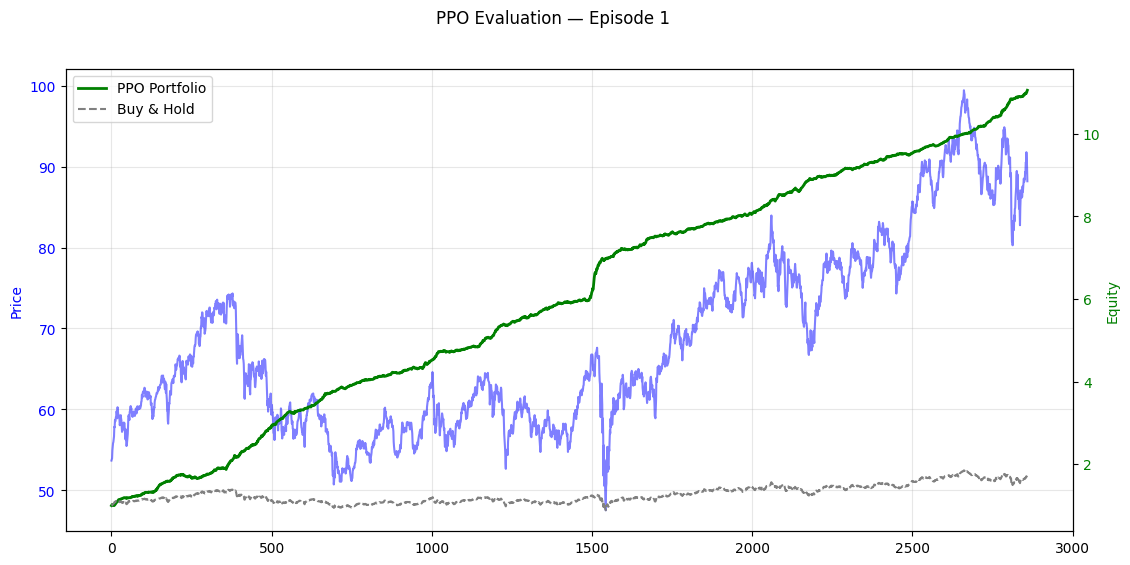


=== EVALUATION COMPLETE ===



In [14]:
vec_env = DummyVecEnv([
    lambda: FlexibleTradingEnv(
        df=df,
        prices=prices,
        signal_features=signal_features,
        window_size=window_size,
        frame_bound=frame_bound,
        fee=0.0005,           # MUST MATCH TRAINING
        holding_cost=0.00001, # MUST MATCH TRAINING
        render_mode=None
    )
])

# Load normalization statistics
vec_env = VecNormalize.load("vec_normalize.pkl", vec_env)
vec_env.training = False
vec_env.norm_reward = False

model = RecurrentPPO.load("recurrent_ppo_trading")

raw_prices = prices
evaluate_agent(model, vec_env, raw_prices, episodes=1)


In [15]:
env = vec_env.venv.envs[0].unwrapped

print("First 10 raw prices:", env.prices[:10])

First 10 raw prices: [53.68 53.84 53.96 54.96 55.35 55.84 55.97 56.31 56.66 57.85]


In [ ]:
obs = vec_env.reset()
for i in range(5):
    obs, reward, done, info = vec_env.step([1])
    print(f"step {i}   reward={reward}   total_profit={info[0]['total_profit']}")


step 0   reward=[-0.0005]   total_profit=-0.0005
step 1   reward=[-0.01322341]   total_profit=-0.013723413400464924
step 2   reward=[-0.01147642]   total_profit=-0.0251998325257348
step 3   reward=[0.00886197]   total_profit=-0.016337857643896933
step 4   reward=[-0.0031323]   total_profit=-0.019470155070486335


: 